# Prática 7: Experimentos - Parte VII

### Kelvin Guilherme de Oliveira - 9293286
### Lucas Yudi Sugi - 9293251

O trabalho desenvolvido nessa atividade prática tem como objetivo realizar uma avaliação do algoritmo de classificação por meio de métricas extraídas da matriz de confusão, da curva ROC e do teste de hipóteses.

Iremos continuar o trabalho desenvolvido na prática 6, na qual foi utilizado o dataset Breast Cancer.

## Dataset: Breast Cancer

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Leitura do dataset com o pandas
dataset = pd.read_csv('./breast_cancer/wdbc.data',sep=',',header=None,encoding='latin1')

#Extração dos atributos necesssários
breast_cancer = dataset.iloc[:,[5,13,16,1]]

#Renomeando as colunas
breast_cancer.columns = ['area','smoothness','texture','class']

#Mostrando os dados
breast_cancer.head()

,area,smoothness,texture,class
0,1001.0,0.9053,0.006399,M
1,1326.0,0.7339,0.005225,M
2,1203.0,0.7869,0.006150,M
3,386.1,1.1560,0.009110,M
4,1297.0,0.7813,0.011490,M


### 1 - Métricas de Avaliação

In [3]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.model_selection import KFold

def classificacao(data, columns, target, folds=5):
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']
    
    # prepara validação cruzada
    cv = KFold(n_splits=folds, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results_test = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    results_pred = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)
            
            # realiza predição no conjunto de teste e salva o resultado
            results_test[c_name] = np.append(y_test,results_test[c_name])
            results_pred[c_name] = np.append(y_pred,results_pred[c_name])

    return results_test, results_pred

In [4]:
#Classificando novamente para retornar os valores preditos e verdadeiros
results_test,results_pred = classificacao(breast_cancer,[0,1,2], 3,folds=10)

In [5]:
from sklearn.metrics import confusion_matrix

#Nomes dos algoritmos
clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']

#Matriz de confusao para cada algoritmo
for c_name in clfs_names:
    #Medidas
    tn, fp, fn, tp = confusion_matrix(results_test[c_name], results_pred[c_name]).ravel()
    
    #Métricas
    rev = tp/(tp+fn)
    prec = tp/(tp+fp)
    print(c_name)
    print('Acurácia: ',(tn+tp)/(tn+fp+fn+tp))
    print('Especificidade: ',tn/(tn+fp))
    print('Revocação/Sensibilidade: ',rev)
    print('Precisão: ',prec)
    print('Medida-F1:',2/((1/prec) + (1/rev)),'\n')

perceptron
Acurácia:  0.546572934973638
Especificidade:  0.6162464985994398
Revocação/Sensibilidade:  0.42924528301886794
Precisão:  0.3991228070175439
Medida-F1: 0.41363636363636364 

svm_poly
Acurácia:  0.5114235500878734
Especificidade:  0.4649859943977591
Revocação/Sensibilidade:  0.589622641509434
Precisão:  0.39556962025316456
Medida-F1: 0.47348484848484845 

dt
Acurácia:  0.8804920913884007
Especificidade:  0.9355742296918768
Revocação/Sensibilidade:  0.7877358490566038
Precisão:  0.8789473684210526
Medida-F1: 0.8308457711442786 

3nn
Acurácia:  0.8611599297012302
Especificidade:  0.9047619047619048
Revocação/Sensibilidade:  0.7877358490566038
Precisão:  0.8308457711442786
Medida-F1: 0.8087167070217917 

5nn
Acurácia:  0.8769771528998243
Especificidade:  0.938375350140056
Revocação/Sensibilidade:  0.7735849056603774
Precisão:  0.8817204301075269
Medida-F1: 0.8241206030150754 

7nn
Acurácia:  0.8875219683655536
Especificidade:  0.957983193277311
Revocação/Sensibilidade:  0.768867

As medidas calculadas a partir da matriz de confusão são interessantes para avaliar o desempenho dos algoritmos de Aprendizado de Máquina. Com as medidas, podemos entender qual dos algoritmos é o mais adequado ao nosso objetivo, contudo, tais medidas precisam ser avaliadas com muito cuidado, pois um dataset mal tratado (sem limpeza, sem transformações e com desbalanceamento) podem levar a conclusões erradas. Por exemplo, caso haja  muitos valores da classe negativo, então a revocação e especificidade será afetada, e, da mesma forma, muitos valores positivos afetaríam a precisão.

Em nosso dataset, não houveram problemas nas medidas. Aparentemente todas elas refletem bem o algoritmo aplicado ao dataset, como pode ser verificado pelos resultados apresentados acima. Além disso, é interessante notar que o 'perceptron' e o 'svm' possuem um desempenho baixo, e os outros classificadores são bem parecidos. Esse mesmo fato já foi observado na prática anterior.

### 2 - Curva ROC e AUC

Para verificar a curva ROC e fazer o cálculo da AUC, escolhemos utilizar os algoritmos classificadores 'dt' e '3nn', apenas por observar que eles possuem um desempenho melhor sobre o conjunto de dados. Para tal, definimos uma nova função 'classificacao', que pode ser observada abaixo.

In [6]:
from sklearn.model_selection import train_test_split

def classificacao(data, columns, target):
    # inicializa os modelos com os parâmetros solicitados
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    
    #Classificadores
    clfs = [dt,_3nn]
    clfs_names = ['dt','3nn']
    
    #Resultado
    results = {'dt':(),'3nn':()}
    
    for c,c_name in zip(clfs,clfs_names):
        #Split em treino (80%) em teste (20%)
        x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,columns],data.iloc[:,target],test_size=0.2)

        # faz o treino do modelo
        clf = c.fit(X=x_train, y=y_train)

        # valores predito pelo classificador
        y_prob = clf.predict_proba(x_test)
        # rótulos verdadeiros convertidos para array
        y_test = np.array(y_test)
        
        #Concatenando valores
        results[c_name] = (y_prob,y_test)
    
    return results

In [7]:
#Probabilidades da previsao e valor esperado
results = classificacao(breast_cancer,[0,1,2], 3)

#Armazenando em novas variáveis
y_prob_3nn = results['3nn'][0]
y_test_3nn = results['3nn'][1]

y_prob_dt = results['dt'][0]
y_test_dt = results['dt'][1]

Após a execução dos algoritmos, com os resultados em mãos pudemos então calcular a curva ROC e a AUC para os dois classificadores executados. Por conta de limitações das funções utilizadas, precisamos binarizar a classe do nosso dataset, o que foi feito abaixo.

In [8]:
#Binarizando
def to_bin(x):
    if(x == 'M'):
        return 1
    else:
        return 0
    
y_test_dt = list(map(to_bin,y_test_dt))
y_test_3nn = list(map(to_bin,y_test_3nn))

#### Plotando a Curva ROC

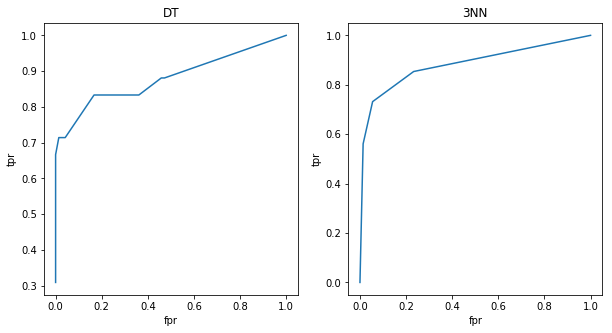

In [9]:
from sklearn.metrics import roc_curve

#Curva ROC
plt.subplots_adjust(wspace=0.5)
plt.suptitle('ROC')
plt.figure(figsize=(10,5))

#ROC - DT
fpr, tpr, thresholds = roc_curve(y_test_dt,y_prob_dt[:,1])
ax = plt.subplot(121)
ax.set_title('DT')
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
plt.plot(fpr,tpr)

#ROC - 3NN
fpr, tpr, thresholds = roc_curve(y_test_3nn,y_prob_3nn[:,1])
ax = plt.subplot(122)
ax.set_title('3NN')
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
plt.plot(fpr,tpr)
plt.show()

#### Calculando a Medida AUC

In [10]:
from sklearn.metrics import roc_auc_score

#Medida AUC
print('AUC DT: ',roc_auc_score(y_test_dt,y_prob_dt[:,1]))
print('AUC 3NN:',roc_auc_score(y_test_3nn,y_prob_3nn[:,1]))

AUC DT:  0.8801256613756614
AUC 3NN: 0.8825593050451052


### 3 - Desempenho dos classificadores

A curva ROC serve para verificar qual relação entre custo (TFP) e benefício (TVP). A sua área é chamada de AUC e, com ela, podemos facilmente verificar qual algoritmo é melhor, pois quanto maior esta medida resumida, melhor o classificador é.

Em nossos gráficos é possível verificar que a árvore decisão ('dt') possui uma área maior, e portanto, tem um melhor desempenho.

### 4 - Teste de hipótese

Iremos realizar o teste de hipótese na finalidade de verificar se os classificadores 3nn e arvóre de decisão possuem valores de erros amostrais iguais. Desse modo, iremos definir que nossa hipótese nula (H0) é tal que a média dos erros de 3nn seja igual a média da árvore de decisão.

Como nossos dados seguem uma distribuição normal iremos utilizar o T-test independente.

In [11]:
def classificacao(data, columns, target,score,folds=5):
    # inicializa os modelos com os parâmetros solicitados
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    
    clfs = [dt, _3nn]
    clfs_names = ['dt','3nn']
    
    # prepara validação cruzada
    cv = KFold(n_splits=folds, shuffle=True)
    
    results = {'dt':[],'3nn':[]}
    for c,c_name in zip(clfs,clfs_names):
        for train_index, test_index in cv.split(data):
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]

            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)

            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)

            #Armazena o erro do classificador
            results[c_name] = np.append(results[c_name],score(y_test, y_pred))
        
    return results

In [12]:
#Definindo função que penaliza a taxa de falso positivo
def pen_falso_positivo(y_true, y_pred):
    count = 0
    for i,j in enumerate(y_pred):
        if y_true[i] == 'B' and j == 'M':
            count += 2
        elif y_true[i] == 'M' and j == 'B':
            count += 1
    return count/len(y_true)

In [13]:
from scipy import stats
from scipy.stats import ttest_ind
np.random.seed(12345678)

# 10-fold Cross Validation
results = classificacao(breast_cancer,[0,1,2], 3, pen_falso_positivo,folds=10)
statistic,pvalue = ttest_ind(results['dt'],results['3nn'])

print('Statistic:', statistic)
print('P-value: ',pvalue)

Statistic: -1.3717275217004035
P-value:  0.18700543442335377


#### Conclusão

Dado um nível de significância (alpha) igual à 5%, é possível constatar que o p-value é maior que 0.05, logo, não há evidências de que deveríamos rejeitar a hipótese, ou de que os erros amostrais são iguais. De qualquer forma é interessante notar que, como o valor da estatística 't' é negativo, temos que a distribuição de erros de 'dt' está mais à esquerda, o que indica que ela possui um erro menor.